CURRENT_DIR: c:\Users\zalma\netflix-data-analysis\codes
BASE_DIR: c:\Users\zalma\netflix-data-analysis
OUTPUT_DIR: c:\Users\zalma\netflix-data-analysis\output

=== Adattisztítás megkezdése ===
Nyers adat beolvasása: c:\Users\zalma\netflix-data-analysis\dataset\netflix_titles.csv
Tisztított adathalmaz létrehozva:
   c:\Users\zalma\netflix-data-analysis\output\netflix_cleaned.csv

A tisztított adat (df) elérhető a memóriában, elemzés indul.

=== EDA ábrák generálása ===


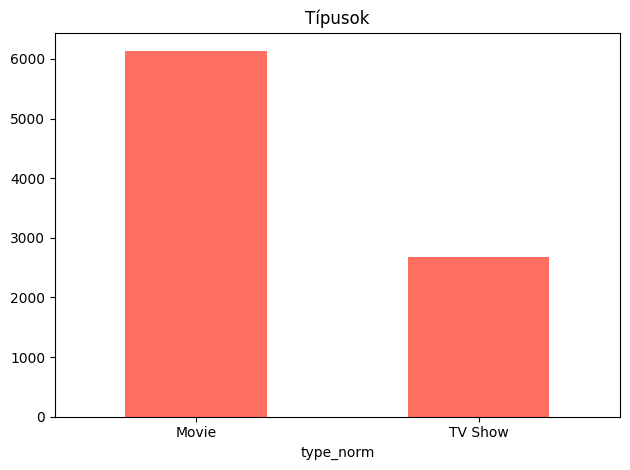

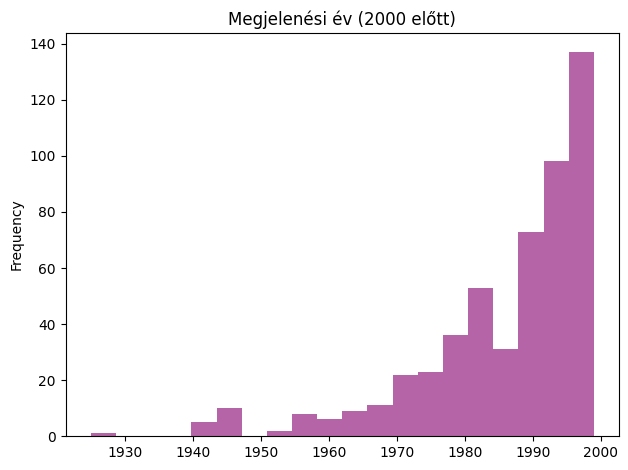

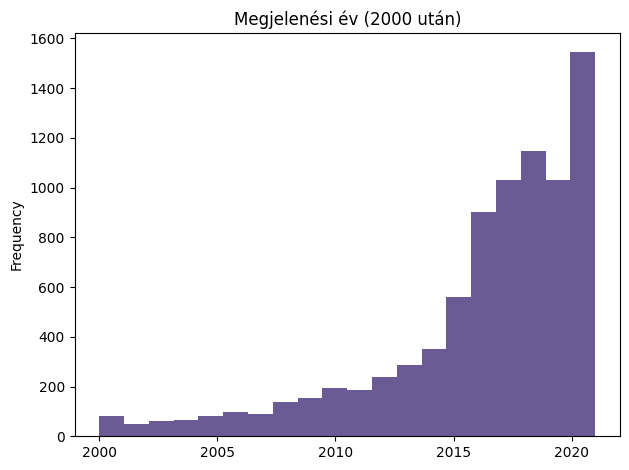

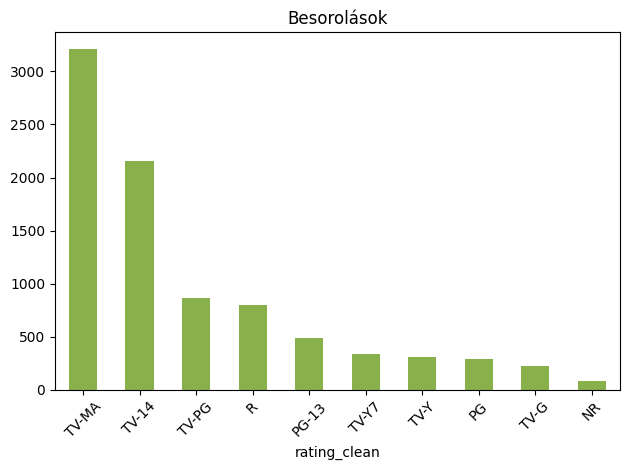

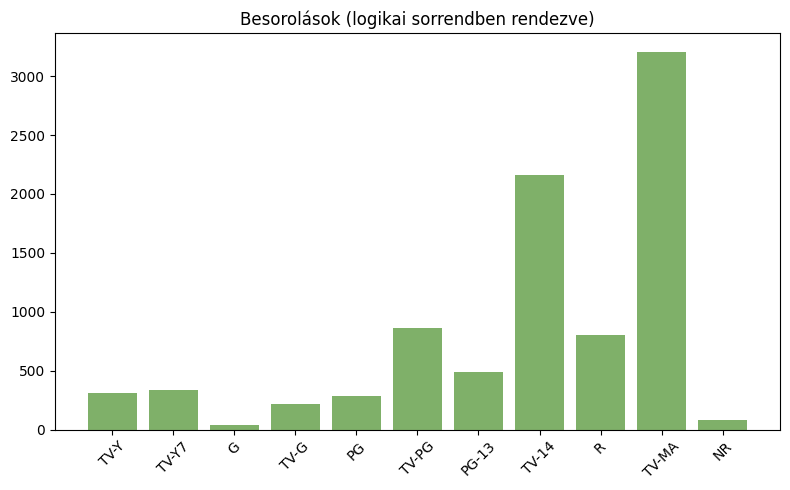

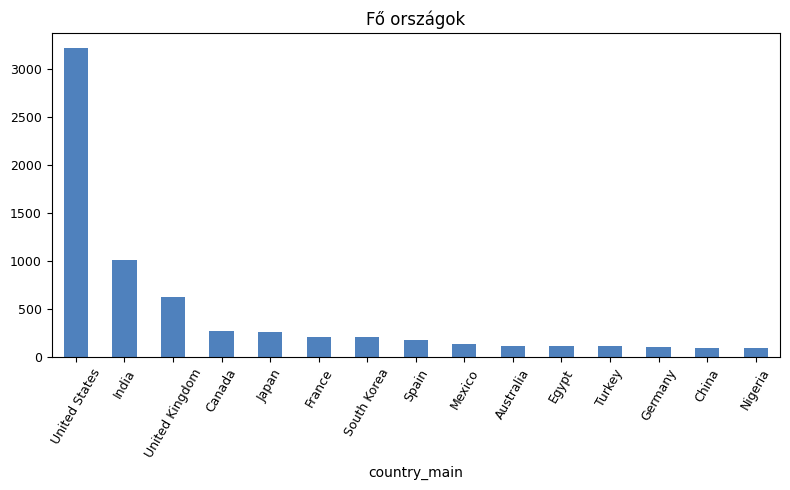

C:\Users\zalma\AppData\Local\Temp\ipykernel_15008\3203226313.py:222: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(


Világtérképes ábra elkészült: c:\Users\zalma\netflix-data-analysis\output\plot_country_world_map.png


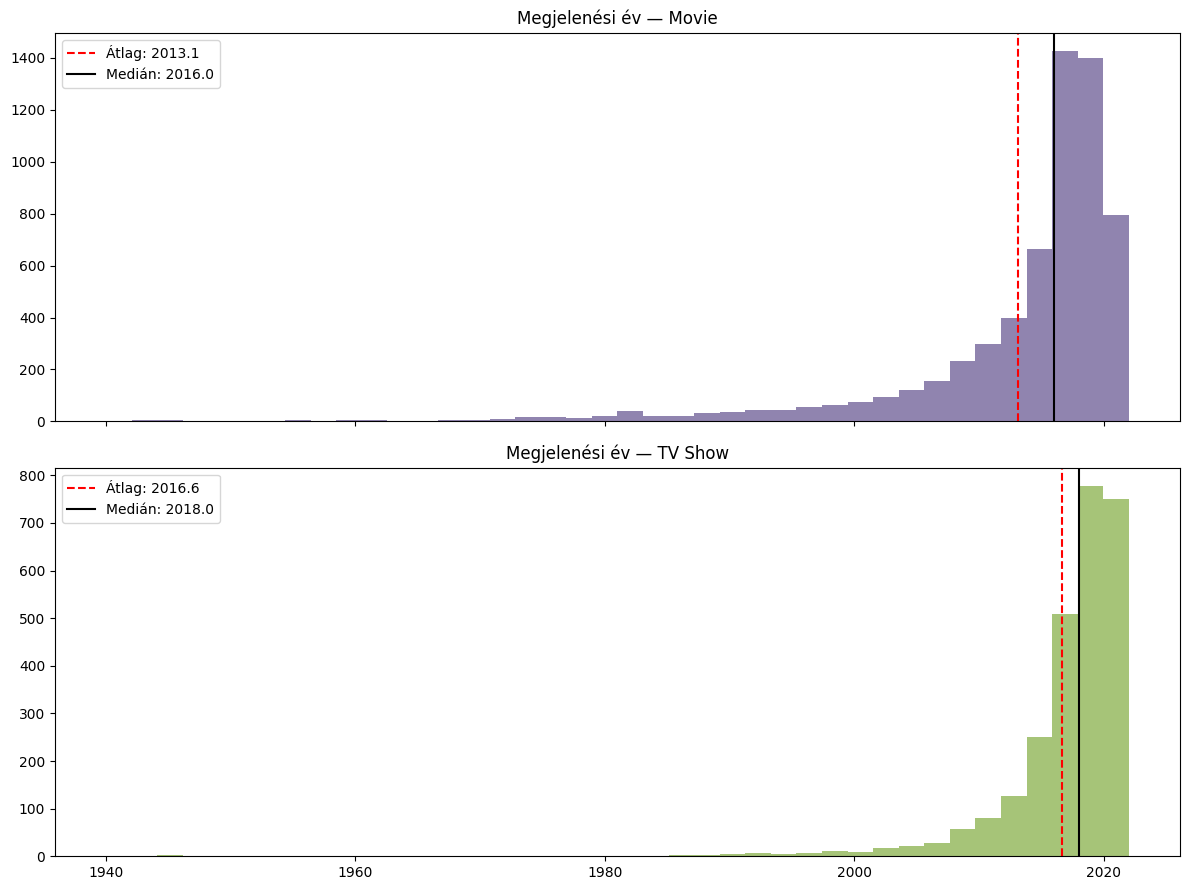


=== Hipotézisvizsgálat ===
Mann–Whitney U statisztika: 5820528.00 | p-érték: 2.051e-105
Filmek medián éve:  2016
Sorozatok medián éve: 2018


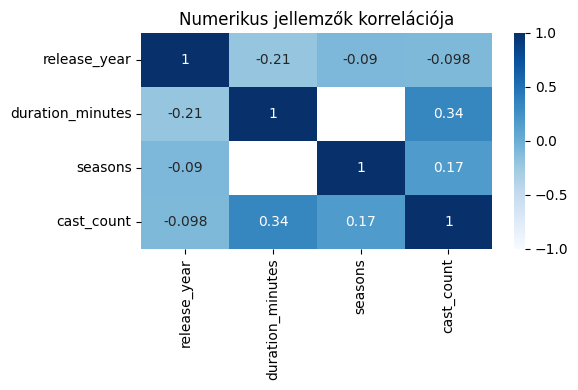


=== Logisztikus regresszió paraméterei ===
Intercept: [-0.55311231]
Koefficiensek száma: 122

=== Modell eredmények ===
Pontosság: 0.998
ROC-AUC:   1.000
              precision    recall  f1-score   support

           0      0.998     0.999     0.999      1533
           1      0.999     0.996     0.997       669

    accuracy                          0.998      2202
   macro avg      0.998     0.997     0.998      2202
weighted avg      0.998     0.998     0.998      2202



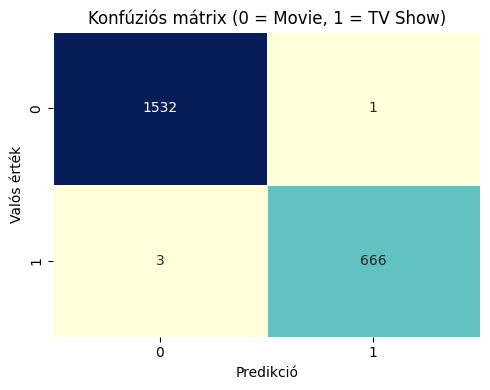


=== Rosszul besorolt példák ===
                                         title type_norm  release_year  \
6347            Bob Ross: Beauty Is Everywhere   TV Show          1991   
2303                               Warrior Nun   TV Show          2020   
726            Metallica: Some Kind of Monster   TV Show          2014   
308   American Masters: Inventing David Geffen     Movie          2012   

      duration_minutes  seasons  
6347               NaN      1.0  
2303               NaN      1.0  
726                NaN      1.0  
308              115.0      NaN  

=== 5-fold Cross Validation ===
Fold pontosságok: [0.99148695 0.99829739 0.99886428 0.99772856 0.99659284]
Átlagos CV pontosság: 0.9965940051861463

=== Példák új adatokra ===

Cím: One Heart: The A.R. Rahman Concert Film
Valós kategória: Movie
Predikció: Movie
Valószínűség TV Show-ra: 0.000

Cím: Abyss
Valós kategória: TV Show
Predikció: TV Show
Valószínűség TV Show-ra: 0.996

Cím: Captain Underpants Epic Choice-o-Rama
V

In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from collections import Counter
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix


# -------------------------------------------------------------------
# 1) Könyvtárstruktúra beállítása
# -------------------------------------------------------------------

try:
    CURRENT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    CURRENT_DIR = os.getcwd()

BASE_DIR = os.path.dirname(CURRENT_DIR)
OUTPUT_DIR = os.path.join(BASE_DIR, "output")

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("CURRENT_DIR:", CURRENT_DIR)
print("BASE_DIR:", BASE_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)

RAW_DATA_PATH = os.path.join(BASE_DIR, "dataset", "netflix_titles.csv") 

CLEAN_DATA_PATH = os.path.join(OUTPUT_DIR, "netflix_cleaned.csv")

# -------------------------------------------------------------------
# 2) Adattisztító segédfüggvények
# -------------------------------------------------------------------

def parse_duration_minutes(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r'(\d+)\s*min', str(x))
    return float(m.group(1)) if m else np.nan


def parse_seasons(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r'(\d+)\s*Season', str(x), re.IGNORECASE)
    return float(m.group(1)) if m else np.nan


def count_persons(x):
    if pd.isna(x) or not isinstance(x, str) or x.strip() == "" or x.strip().lower() == "nan":
        return 0
    return len([p for p in [i.strip() for i in x.split(",")] if p])


def first_country(x):
    if pd.isna(x) or not isinstance(x, str) or x.strip() == "" or x.strip().lower() == "nan":
        return np.nan
    return x.split(",")[0].strip()


def clean_rating(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().upper()
    mapping = {
        "UR": "NR",
        "TV MA": "TV-MA",
        "TV 14": "TV-14",
        "TV PG": "TV-PG",
        "TV Y7": "TV-Y7",
        "TV Y": "TV-Y"
    }
    return mapping.get(x, x)


def split_genres(x):
    if pd.isna(x) or not isinstance(x, str) or x.strip() == "" or x.strip().lower() == "nan":
        return []
    return [g.strip() for g in x.split(",")]


# -------------------------------------------------------------------
# 3) Adattisztítás végrehajtása
# -------------------------------------------------------------------
print("\n=== Adattisztítás megkezdése ===")

if not os.path.isfile(RAW_DATA_PATH):
    print(f"Hiba: a forrásfájl nem létezik: {RAW_DATA_PATH}")
    print("Kérlek, ellenőrizd a RAW_DATA_PATH változót és a könyvtárstruktúrát.")
    sys.exit(1)

print(f"Nyers adat beolvasása: {RAW_DATA_PATH}")
df_raw = pd.read_csv(RAW_DATA_PATH)
df_raw.columns = [c.strip() for c in df_raw.columns]

for col in df_raw.select_dtypes(include=['object']).columns:
    df_raw[col] = df_raw[col].astype(str).str.strip().replace({"nan": np.nan})

if 'date_added' in df_raw.columns:
    df_raw['date_added_parsed'] = pd.to_datetime(df_raw['date_added'], errors='coerce')

df_raw['type_norm'] = df_raw['type'].apply(
    lambda x: 'TV Show' if isinstance(x, str) and re.search(r'tv\s*show', x, flags=re.I)
    else ('Movie' if isinstance(x, str) and re.search(r'movie', x, flags=re.I) else np.nan)
)

df_raw['duration_minutes'] = df_raw['duration'].apply(parse_duration_minutes)
df_raw['seasons'] = df_raw['duration'].apply(parse_seasons)

df_raw['cast_count'] = df_raw['cast'].apply(count_persons) if 'cast' in df_raw.columns else 0
df_raw['country_main'] = df_raw['country'].apply(first_country)
df_raw['rating_clean'] = df_raw['rating'].apply(clean_rating)
df_raw['genre_list'] = df_raw['listed_in'].apply(split_genres)

genre_counter = Counter()
for gs in df_raw['genre_list']:
    genre_counter.update(gs)

top_genres = [g for g, _ in genre_counter.most_common(20)]
for g in top_genres:
    df_raw[f"genre_{g}"] = df_raw['genre_list'].apply(lambda lst: 1 if g in lst else 0)

df = df_raw.copy()

df.to_csv(CLEAN_DATA_PATH, index=False, encoding="utf-8")
print(f"Tisztított adathalmaz létrehozva:\n   {CLEAN_DATA_PATH}")


# -------------------------------------------------------------------
# 4) Tiszta adat beolvasása
# -------------------------------------------------------------------

print("\nA tisztított adat (df) elérhető a memóriában, elemzés indul.")

# -------------------------------------------------------------------
# 5) Exploratory Data Analysis (EDA)
# -------------------------------------------------------------------
print("\n=== EDA ábrák generálása ===")

plt.figure()
df['type_norm'].value_counts(dropna=False).plot(kind='bar', rot=0, color='#FF6F61')
plt.title("Típusok")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plot_type_counts.png"))
plt.show()
plt.close()

plt.figure()
df[df['release_year'] < 2000]['release_year'] \
    .astype(int) \
    .plot(kind='hist', bins=20, color='#B565A7')
plt.title("Megjelenési év (2000 előtt)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plot_release_year_before2000.png"))
plt.show()
plt.close()

plt.figure()
df[df['release_year'] >= 2000]['release_year'] \
    .astype(int) \
    .plot(kind='hist', bins=20, color='#6B5B95')
plt.title("Megjelenési év (2000 után)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plot_release_year_after2000.png"))
plt.show()
plt.close()

plt.figure()
df['rating_clean'].value_counts().head(10).plot(kind='bar', rot=45, color='#88B04B')
plt.title("Besorolások")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plot_rating_top10.png"))
plt.show()
plt.close()

rating_order = [
    "TV-Y", "TV-Y7", "G", "TV-G", "PG",
    "TV-PG", "PG-13", "TV-14", "R", "TV-MA", "NR"
]

rating_counts = df['rating_clean'].value_counts()

ordered_counts = [rating_counts.get(r, 0) for r in rating_order]

plt.figure(figsize=(8,5))
plt.bar(rating_order, ordered_counts, color="#7FB069")
plt.xticks(rotation=45)
plt.title("Besorolások (logikai sorrendben rendezve)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plot_rating_ordered.png"))
plt.show()
plt.close()

plt.figure(figsize=(8, 5))
df['country_main'].value_counts().head(15).plot(
    kind='bar',
    color='#4F81BD',
    rot=60,
    fontsize=9
)
plt.title("Fő országok")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plot_country_top15.png"))
plt.show()
plt.close()

country_counts = df['country_main'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

fig = px.choropleth(
    country_counts,
    locations='country',
    locationmode='country names',
    color='count',
    color_continuous_scale='Blues',
    title='Netflix tartalmak előfordulása országonként'
)

fig.update_layout(
    width=1200,
    height=650,
    margin=dict(l=50, r=50, t=80, b=20)
)

fig.show()
map_path = os.path.join(OUTPUT_DIR, "plot_country_world_map.png")
fig.write_image(map_path)

print("Világtérképes ábra elkészült:", map_path)

tmp = df[['type_norm', 'release_year']].dropna().copy()
tmp['release_year'] = tmp['release_year'].astype(float)

data_movie = tmp.loc[tmp['type_norm'] == 'Movie', 'release_year'].values
data_tv = tmp.loc[tmp['type_norm'] == 'TV Show', 'release_year'].values

# -------------------------------------------------------------------
# Hisztogram Movie / TV Show — átlag + medián jelöléssel
# -------------------------------------------------------------------

fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

year_min = 1940
year_max = 2022
bins = 40

# Movie
axes[0].hist(data_movie, bins=bins, range=(year_min, year_max), color='#6B5B95', alpha=0.75)
axes[0].axvline(np.mean(data_movie), color='red', linestyle='--', label=f'Átlag: {np.mean(data_movie):.1f}')
axes[0].axvline(np.median(data_movie), color='black', linestyle='-', label=f'Medián: {np.median(data_movie):.1f}')
axes[0].set_title("Megjelenési év — Movie")
axes[0].legend()

# TV Show
axes[1].hist(data_tv, bins=bins, range=(year_min, year_max), color='#88B04B', alpha=0.75)
axes[1].axvline(np.mean(data_tv), color='red', linestyle='--', label=f'Átlag: {np.mean(data_tv):.1f}')
axes[1].axvline(np.median(data_tv), color='black', linestyle='-', label=f'Medián: {np.median(data_tv):.1f}')
axes[1].set_title("Megjelenési év — TV Show")
axes[1].legend()

fig.tight_layout()

save_path = os.path.join(OUTPUT_DIR, "plot_year_hist_by_type.png")
fig.savefig(save_path)

plt.show()
plt.close(fig)


# -------------------------------------------------------------------
# 6) Hipotézisvizsgálat (Mann–Whitney U-teszt)
# -------------------------------------------------------------------

movies_year = df.loc[df['type_norm'] == 'Movie', 'release_year'].dropna().astype(int)
tv_year = df.loc[df['type_norm'] == 'TV Show', 'release_year'].dropna().astype(int)

mw_stat, mw_p = mannwhitneyu(movies_year, tv_year, alternative='two-sided')
print("\n=== Hipotézisvizsgálat ===")
print(f"Mann–Whitney U statisztika: {mw_stat:.2f} | p-érték: {mw_p:.3e}")
print(f"Filmek medián éve:  {np.median(movies_year):.0f}")
print(f"Sorozatok medián éve: {np.median(tv_year):.0f}")


# -------------------------------------------------------------------
# 7) Osztályozás – Logistic Regression
# -------------------------------------------------------------------

df_model = df[df['type_norm'].isin(['Movie', 'TV Show'])].copy()
y = (df_model['type_norm'] == 'TV Show').astype(int)

numeric_features = ['release_year', 'duration_minutes', 'seasons', 'cast_count']
categorical_features = ['rating_clean', 'country_main']
genre_features = [c for c in df_model.columns if c.startswith('genre_')]

# Numerikus típusra konvertálás
for col in numeric_features + genre_features:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

X = df_model[numeric_features + categorical_features + genre_features].copy()


# -----------------------------
# EXTRA 1: Numerikus korrelációk
# -----------------------------
plt.figure(figsize=(6, 4))
sns.heatmap(df_model[numeric_features].corr(), annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.title("Numerikus jellemzők korrelációja")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plot_numeric_correlations.png"))
plt.show()
plt.close()


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


# Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

genre_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, keep_empty_features=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('gen', genre_transformer, genre_features)
    ],
    remainder='drop'
)

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=400))
])

# Modell betanítása
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]


# --------------------------------------
# EXTRA 2: Logisztikus regresszió súlyai
# --------------------------------------
log_reg = clf.named_steps['model']
print("\n=== Logisztikus regresszió paraméterei ===")
print("Intercept:", log_reg.intercept_)
print("Koefficiensek száma:", len(log_reg.coef_[0]))


# ---------------------------
# Eredmény mutatók kiírása
# ---------------------------
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print("\n=== Modell eredmények ===")
print(f"Pontosság: {acc:.3f}")
print(f"ROC-AUC:   {roc:.3f}")
print(classification_report(y_test, y_pred, digits=3))


# ---------------------------
# Konfúziós mátrix ábra
# ---------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='white',
    cbar=False
)
plt.title("Konfúziós mátrix (0 = Movie, 1 = TV Show)")
plt.xlabel("Predikció")
plt.ylabel("Valós érték")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plot_confusion_matrix.png"))
plt.show()
plt.close()


# -------------------------------------
# EXTRA 3: Rosszul besorolt minták
# -------------------------------------
misclassified_idx = X_test.index[y_test != y_pred]

print("\n=== Rosszul besorolt példák ===")
print(
    df_model.loc[
        misclassified_idx,
        ["title", "type_norm", "release_year", "duration_minutes", "seasons"]
    ].head(5)
)


# -------------------------------------
# EXTRA 4: 5-fold Cross Validation
# -------------------------------------
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("\n=== 5-fold Cross Validation ===")
print("Fold pontosságok:", cv_scores)
print("Átlagos CV pontosság:", np.mean(cv_scores))

# -------------------------------------
# EXTRA 5: Modell alkalmazása új adatokon
# -------------------------------------
sample_idx = np.random.choice(X_test.index, size=5, replace=False)
sample_X = X_test.loc[sample_idx]
sample_y = y_test.loc[sample_idx]

sample_pred = clf.predict(sample_X)
sample_proba = clf.predict_proba(sample_X)[:, 1]

print("\n=== Példák új adatokra ===")
for i, idx in enumerate(sample_idx):
    print(f"\nCím: {df_model.loc[idx, 'title']}")
    print(f"Valós kategória: {df_model.loc[idx, 'type_norm']}")
    print(f"Predikció: {'TV Show' if sample_pred[i] == 1 else 'Movie'}")
    print(f"Valószínűség TV Show-ra: {sample_proba[i]:.3f}")

print("\n=== Teljes folyamat lefuttatva. ===")